# Image Captioning

**Image captioning** is a vision–language task that generates a **natural-language description** for an image.
The model outputs a **sequence of tokens** (e.g., $w_1,\dots,w_T$), each with a **probability**, forming a fluent caption that names objects, attributes, and relations.

### How it differs from related tasks

* **Image classification:** one label; captioning yields a full sentence (richer semantics).
* **Detection:** localizes objects; captioning describes them and their relationships in language.
* **Segmentation (instance/semantic):** pixel-level masks; captioning provides textual summaries instead.
* **VQA / tagging / retrieval:** VQA answers a specific question; tagging gives unordered labels; retrieval ranks matches—captioning **generates** free text.

### Typical pipeline (modern captioners)

1. **Vision encoder** (CNN or **ViT**) extracts image features (global or per-patch).
2. **Multimodal connector/fusion** (e.g., projection layer, Q-Former, cross-attention) maps vision features into the language space.
3. **Text decoder** (autoregressive Transformer/LLM) generates the caption token-by-token.
4. **Decoding** (greedy, beam search, nucleus sampling) and optional **reranking**/constraints to improve fluency and factuality.

### Model families

* **Encoder–decoder Transformers:** vision encoder + language decoder with cross-attention (e.g., ViT-GPT2/T5, OFA).
* **Frozen LLM + visual adapter:** lightweight connector feeds vision features to a frozen LLM (e.g., **BLIP-2**, **LLaVA**, InstructBLIP).
* **Classic CNN–RNN with attention:** “Show, Attend and Tell”-style models (historical baseline).

### Losses & metrics

* **Losses:** token-level **cross-entropy** (often with label smoothing); sequence-level **RL** objectives (e.g., self-critical training) to optimize metrics like CIDEr; auxiliary **contrastive/alignment** losses in pretraining.
* **Metrics:** **BLEU**, **METEOR**, **ROUGE-L**, **CIDEr-D**, **SPICE** (each has limits—high scores don’t always mean human-preferred captions).

### Common datasets / formats

* **MS COCO Captions**, **Flickr8k/30k**, **Conceptual Captions**; images paired with **multiple reference captions** (often COCO-style JSON annotations).

### Practical notes

* Main challenges: **hallucination**, weak grounding, domain shift, and noisy web captions; control caption length/style as needed.
* Strong results typically come from **large-scale vision–language pretraining** plus careful decoding and prompt conditioning.


In [ ]:
!pip install transformers datasets evaluate -q
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.8 MB/s eta 0:00:00


In this tutorial we will work with **Flickr** dataset and image captioing task. We will:
- Fine-tune an image captioning model.
- Use the fine-tuned model for inference.

In [ ]:
from datasets import load_dataset

ds = load_dataset("Mozilla/flickr30k-transformed-captions-gpt4o", split="test[:200]")
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00003.parquet:   0%|          | 0.00/405M [00:00<?, ?B/s]

data/test-00001-of-00003.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

data/test-00002-of-00003.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text', 'objects'],
    num_rows: 200
})

Let's explore the dataset

In [1]:
ds.features

NameError: name 'ds' is not defined

In [ ]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'alt_text': 'People standing near a garden gate surrounded by greenery.',
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg',
 'original_alt_text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.'],
 'objects': ['people', 'garden gate', 'greenery', 'bushes', 'path']}

> *Hint*

- In many caption datasets, each image has several human‑written descriptions.

- Instead of duplicating the image for every caption, a common training tactic is to sample one caption at *random* for that image on each iteration.

- Over multiple epochs, the model still sees all available captions, but it doesn’t inflate the dataset size or overweight frequent images.

- Sampling different captions exposes the model to diverse phrasings, improving generalization and reducing overfitting to a single wording.

- **Alternatives** include treating every image‑caption pair as its own example or cycling through captions in order, but random selection strikes a balance between efficiency and diversity.

Caption:A person on roller skates talks on a phone outside.


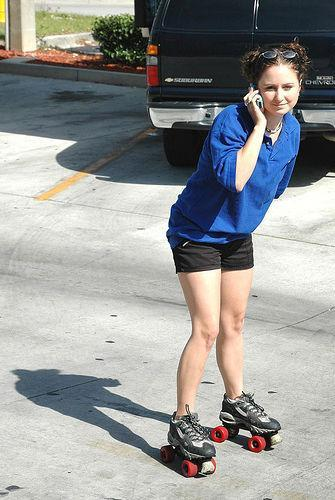

In [ ]:
print(f"Caption:{ds['alt_text'][7]}")
ds['image'][7]

Split the dataset’s train split into a **train** and **test** set with the `train_test_split` method:

In [ ]:
ds = ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

Let’s visualize a couple of samples from the training set.

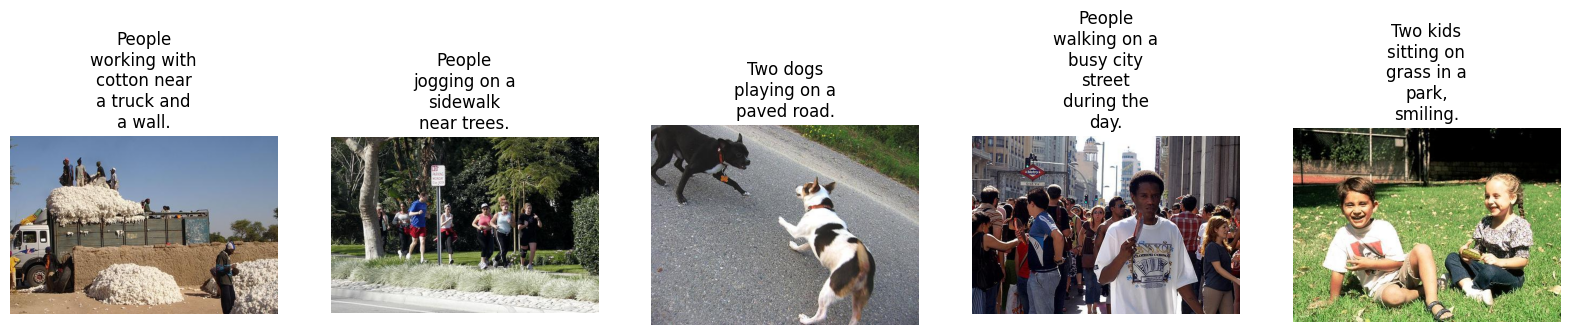

In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["alt_text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

**Preprocessing**

* Our dataset is **multimodal**: each example has an **image** and a **caption** (text=`alt_text`).
* Before feeding data to the model, you must:

  * **Process images** (resize, crop/center-pad if needed, normalize with the model’s mean/std, convert to tensors).
  * **Process text** (tokenize into IDs, add BOS/EOS, pad/truncate to a max length, build attention masks).
* The **processor class** bundled with a checkpoint (e.g., `AutoProcessor`, `Blip2Processor`, `LlavaProcessor`) **knows the exact settings** that match that model: image size, color space, normalization constants, vocabulary, special tokens, etc. Using the model’s own processor prevents subtle mismatches.



**GIT (GenerativeImage2Text): model description**

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg" alt="GIT Architecture" width="600"/>

1. **Image → tokens:** The image is passed through a vision encoder (e.g., CLIP ViT) to produce a sequence of **image patch embeddings**. A small projection maps them to the LM’s hidden size. These become a **fixed prefix** of the sequence.
2. **Text → tokens:** The caption text is tokenized into subword IDs and embedded.
3. **Single stream:** The model sees a **concatenated sequence**

**Text decoder (yellow):** a decoder-only Transformer takes a **single stream**:

   ```
   [ image_tokens ] + [ BOS, w1, w2, ... ]
   ```
and predicts the next text token at each step.

> *Hint*: **BOS** = **Begin-Of-Sequence** token. It’s a special token placed at the **start** of the text stream so an autoregressive decoder knows “this is the beginning—start generating after this.”

In the sequence

```
[ image_tokens, BOS, w1, w2, … ]
```

* At step 1 the model sees **image tokens + BOS** and predicts **w1**.
* At later steps it sees image tokens + BOS + previous words (causal mask) and predicts the next word.

> *More Hints*:

* Names vary: `<bos>`, `<s>`, `[BOS]`, sometimes the same as a model’s start token.
* **EOS** (End-Of-Sequence) marks the end; generation usually stops when EOS is produced.
* **\[CLS] ≠ BOS**: `[CLS]` in encoder models (e.g., BERT) is a pooled representation token, not a start token for generation.

### Alternative models: BLIP / BLIP-2

**BLIP**: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation. [Paper](https://arxiv.org/pdf/2201.12086)

<img src="https://cdn-uploads.huggingface.co/production/uploads/1670928184033-62441d1d9fdefb55a0b7d12c.gif" alt="BLIP Architecture" width="600"/>




**GIT** = “just generate”: Simple and effective for captioning/VQA.

**BLIP** = “align + verify + generate”: Better grounding and retrieval, plus strong generation.

Compared to **GIT**, **BLIP** is a different model architecture:

**GIT**: *Decoder-only Transformer (autoregressive LM)*. A CLIP ViT produces image tokens that are projected and concatenated as a prefix to the text stream. No separate text encoder; no cross-attention blocks.

**BLIP**: *Encoder + Decoder stack.* A vision encoder and a text encoder (bidirectional) are used for understanding/pretraining; a text decoder (causal) generates text and uses cross-attention to image features.

1. **Image → tokens:** The image is passed through a **vision encoder (ViT)** to produce a sequence of **image patch embeddings**. A small projection maps them to the model’s hidden size. These image embeddings are kept as a **separate key/value memory** that the text module can attend to (used by BLIP’s ITC/ITM/LM pretraining).

2. **Text → tokens:** The caption/question text is tokenized into subword IDs and embedded.

BLIP has both two text modules:

**Text encoder (bidirectional)** — for *understanding/alignment*

   * Like BERT: every text token can see **all** other text tokens (left **and** right).
   * It is **image-grounded**: it can also (via fusion) look at the image features.
   * Used with **ITC/ITM** pretraining:

     * **ITC** (contrastive): align global image/text spaces.
     * **ITM** (matching): binary “does this caption match this image?” (often with hard negatives).

**Text decoder (causal)** — for *generation*

   * Autoregressive LM: token at position *t* can see **only past** tokens (left-to-right).
   * Also **image-grounded**: each step cross-attends to the image features.
   * Trained with **LM loss** (teacher forcing) to generate captions/answers.

3. **Single stream:** Conceptually, generation proceeds over a **text stream** while **cross-attending** to the fixed image tokens (the image is not concatenated into the autoregressive stream; it’s read via cross-attention each step).

> *Hint*:
- **GIT:** put `[image_tokens]` directly **in front of** the text tokens and use a **prefix-LM** mask (one self-attention stream).

- **BLIP:** keep image tokens **separate** as K/V memory; text **cross-attends** to them each step.

Another critical difference is in the **Conditioning mechanism** (*how image meets text*):

**GIT**: Uses prefix-LM masking.

[ image_tokens ] + [ BOS, w1, w2, ... ]

Text tokens can attend to all image tokens and past text; image tokens do not attend to text.

**BLIP**: Uses **Cross-attention**.
Decoder generates over the *text stream* and queries the *fixed set of image features* via **cross-attention** each step (image isn’t literally concatenated into the autoregressive stream).



In [ ]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In this case we start with `microsoft/git-base` [model](https://huggingface.co/microsoft/git-base) which has a matching preprocessor paired processor (it wraps a CLIP image preprocessor + a BERT tokenizer) so both modalities are prepared exactly as GIT expects.



In [ ]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["alt_text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.


In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

For evaluation we will use the traditional scores, Word Error Rate (WER). And alternative is to use Rouge Score.

>*Hint*: Lower is better.
**WER** treats the reference caption(s) as the “gold transcript” and the model’s caption as the “hypothesis.”

In [ ]:
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.0 MB/s eta 0:00:00


In [ ]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-flickr",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 370.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 168.12 MiB is free. Process 26020 has 14.57 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 347.46 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

We can now test our fine-tuned model running infererence on a sample image:

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image



Prepare the image for inference



In [ ]:
from transformers import infer_device

device = infer_device()
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values


Generate predictions

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

------------
In case your Google Colab is misbehaving and you are running out of resources at this stage, you will need to free memory/disk space.

In [ ]:
import torch
import gc
import os

# Clear PyTorch cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Force garbage collection
gc.collect()

# Check current memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU memory allocated: 14.11 GB
GPU memory cached: 14.45 GB


In [ ]:
# Run this cell first to restart and clear everything
import os
os._exit(00)  # Force quit and restart runtime